# Time Series Prediction with Lorrenz Attractor Inspired Deep Learning ($LPINN$)

AUTHOR: Anurag Dutta (anuragdutta.research@gmail.com)

SUPERVISOR: Tanujit Chakraborty (tanujit.chakraborty@sorbonne.ae)

CREATED: 2023-03-12 16:30:51

## Gathering Dependencies

_Importing Required Libraries_

In [13]:
pip install hampel

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Anurag Dutta\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [14]:
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
import keras
import tensorflow as tf
from hampel import hampel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Pretraining

_Lorrenz Intermittency_

The `lorrenz_intermittency.dat` is generated from the Runge Kutta Method.

This feeds the model with the dynamics of the Lorrenz Attractor

In [15]:
data = np.genfromtxt('datasets/lorrenz_intermittency.dat')
training_set = pd.DataFrame(data).reset_index(drop=True)
training_set = training_set.iloc[:,1]

## Computing the Gradients

_Calculating the value of_ $\frac{dx}{dt}$, _and_ $\frac{d^2x}{dt^2}$

In [16]:
t_diff = 7 # Weekly Data
print(training_set.max())
gradient_t = (training_set.diff()/t_diff).iloc[1:]
print(gradient_t)
gradient_tt = (gradient_t.diff()/t_diff).iloc[1:]
print(gradient_tt)

28.981277697415116
1         0.002440
2         0.005852
3         0.008959
4         0.011882
5         0.014722
            ...   
139867    0.014918
139868    0.009196
139869    0.004054
139870   -0.000537
139871   -0.004624
Name: 1, Length: 139871, dtype: float64
2         0.000488
3         0.000444
4         0.000418
5         0.000406
6         0.000406
            ...   
139867   -0.000901
139868   -0.000817
139869   -0.000735
139870   -0.000656
139871   -0.000584
Name: 1, Length: 139870, dtype: float64


## Loading Datasets

_EL NINO_

In [17]:
data = pd.read_csv("datasets/elnino.csv")
training_set = data.iloc[:, 1]
print(training_set)

0       23.4
1       23.4
2       24.2
3       24.4
4       25.1
        ... 
1629    25.4
1630    24.9
1631    25.3
1632    24.7
1633    24.6
Name: SST1, Length: 1634, dtype: float64


In [18]:
training_set = training_set.reset_index(drop=True)
gradient_t = gradient_t.reset_index(drop=True)
gradient_tt = gradient_tt.reset_index(drop=True)
print(gradient_t)
print(gradient_tt)

0         0.002440
1         0.005852
2         0.008959
3         0.011882
4         0.014722
            ...   
139866    0.014918
139867    0.009196
139868    0.004054
139869   -0.000537
139870   -0.004624
Name: 1, Length: 139871, dtype: float64
0         0.000488
1         0.000444
2         0.000418
3         0.000406
4         0.000406
            ...   
139865   -0.000901
139866   -0.000817
139867   -0.000735
139868   -0.000656
139869   -0.000584
Name: 1, Length: 139870, dtype: float64


In [19]:
print(gradient_t.shape)
print(training_set.shape[:-1])
df = pd.concat((training_set[:-1], gradient_t), axis=1)
gradient_tt.columns = ["grad_tt"]
df = pd.concat((df[:-1], gradient_tt), axis=1)
df.columns = ['y_t', 'grad_t', 'grad_tt']

(139871,)
()


## Preprocessing the Data into Supervised Learning

In [20]:
def Supervised(data, n_in=1):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    cols.append(df)
    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    sup = pd.concat(cols, axis=1)
    sup.columns = names
    sup.dropna(inplace=True)
    return sup


data = Supervised(df.values, n_in=10)
data.drop(['var2(t-10)', 'var3(t-10)', 'var2(t-9)', 'var3(t-9)', 'var2(t-8)',
           'var3(t-8)', 'var2(t-7)', 'var3(t-7)', 'var2(t-6)', 'var3(t-6)',
           'var2(t-5)', 'var3(t-5)', 'var2(t-4)', 'var3(t-4)', 'var2(t-2)',
           'var3(t-2)', 'var2(t-1)', 'var3(t-1)', 'var2(t-3)', 'var3(t-3)'], axis=1, inplace=True)
print(data.head())
print(data.columns)
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data.shape)
y = data[:, -3:]
x = data[:, :-3]
print(x.shape)


    var1(t-10)  var1(t-9)  var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  \
10        23.4       23.4       24.2       24.4       25.1       25.8   
11        23.4       24.2       24.4       25.1       25.8       25.9   
12        24.2       24.4       25.1       25.8       25.9       26.1   
13        24.4       25.1       25.8       25.9       26.1       26.1   
14        25.1       25.8       25.9       26.1       26.1       26.7   

    var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  var1(t)   var2(t)   var3(t)  
10       25.9       26.1       26.1       26.7     26.1  0.034146  0.000600  
11       26.1       26.1       26.7       26.1     26.1  0.038344  0.000660  
12       26.1       26.7       26.1       26.1     25.7  0.042966  0.000729  
13       26.7       26.1       26.1       25.7     25.6  0.048068  0.000806  
14       26.1       26.1       25.7       25.6     25.1  0.053711  0.000892  
Index(['var1(t-10)', 'var1(t-9)', 'var1(t-8)', 'var1(t-7)', 'var1(t-6)',
       'var1(t-5)', 

## Train and Test Split

In [21]:
train_size = int(len(y) * 0.8)
test_size = len(y) - train_size
dataX = np.array(x)
dataY = np.array(y)
trainX = np.array(x[0:train_size])
trainY = np.array(y[0:train_size])
testX = np.array(x[train_size:len(x)])
testY = np.array(y[train_size:len(y)])
trainX = trainX.reshape((trainX.shape[0], 1, trainX.shape[1]))
testX = testX.reshape((testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(1298, 1, 10) (1298, 3) (325, 1, 10) (325, 3)


## Model ($LPINN$)

In [22]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(3))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=500, batch_size=64,
                    validation_data=(testX, testY), verbose=2, shuffle=False)

Epoch 1/500
21/21 - 16s - loss: 0.3123 - val_loss: 0.2124 - 16s/epoch - 770ms/step
Epoch 2/500
21/21 - 0s - loss: 0.1475 - val_loss: 0.0791 - 268ms/epoch - 13ms/step
Epoch 3/500
21/21 - 0s - loss: 0.0603 - val_loss: 0.0395 - 271ms/epoch - 13ms/step
Epoch 4/500
21/21 - 0s - loss: 0.0432 - val_loss: 0.0370 - 267ms/epoch - 13ms/step
Epoch 5/500
21/21 - 0s - loss: 0.0397 - val_loss: 0.0328 - 324ms/epoch - 15ms/step
Epoch 6/500
21/21 - 0s - loss: 0.0358 - val_loss: 0.0293 - 391ms/epoch - 19ms/step
Epoch 7/500
21/21 - 0s - loss: 0.0323 - val_loss: 0.0262 - 331ms/epoch - 16ms/step
Epoch 8/500
21/21 - 0s - loss: 0.0291 - val_loss: 0.0232 - 292ms/epoch - 14ms/step
Epoch 9/500
21/21 - 0s - loss: 0.0260 - val_loss: 0.0204 - 240ms/epoch - 11ms/step
Epoch 10/500
21/21 - 0s - loss: 0.0230 - val_loss: 0.0177 - 259ms/epoch - 12ms/step
Epoch 11/500
21/21 - 0s - loss: 0.0203 - val_loss: 0.0151 - 348ms/epoch - 17ms/step
Epoch 12/500
21/21 - 0s - loss: 0.0177 - val_loss: 0.0128 - 395ms/epoch - 19ms/step
E

## Metrics ($LPINN$)

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
yhat = model.predict(testX)
print(yhat.shape)
testX = testX.reshape((testX.shape[0], testX.shape[2]))
print(testX.shape)
inv_yhat = np.concatenate((testX, yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat1 = inv_yhat[:, -3:]
inv_yhat = inv_yhat[:, -3]
inv_y = np.concatenate((testX, testY), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y1 = inv_y[:, -3:]
inv_y = inv_y[:, -3]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

11/11 [==============================] - 3s 6ms/step
(325, 3)
(325, 10)
Test RMSE: 0.430
Test MAE: 0.336


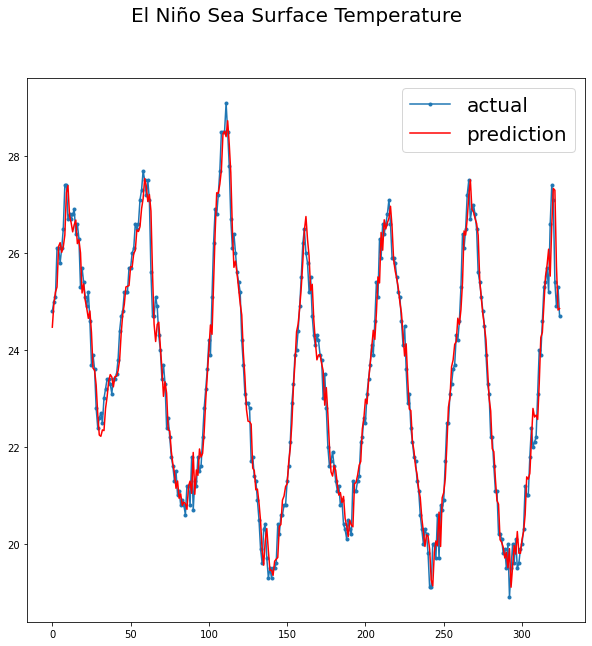

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10] # for square canvas
plt.plot(inv_y, marker='.', label="actual")
plt.plot(inv_yhat, 'r', label="prediction")
plt.suptitle('El Niño Sea Surface Temperature', fontsize=20)
plt.legend(fontsize=20)
plt.show()